In [12]:
import json
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
from sklearn import metrics
import math


In [1]:
from datasets import load_dataset
dataset = load_dataset("yelp_review_full")

import pandas as pd
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [2]:
x = train_df[:65000]['text']
y = train_df[:65000]['label']

In [3]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.4 MB/s eta 0:00:00


In [9]:
import json
import contractions
import re
slang_dict = json.load(open('/kaggle/input/english-slang/slang.json', 'r'))
def preprocess(text):
    # Convert text to UTF-8 encoding
    text = text.encode('utf-8').decode('utf-8')

    # Convert special characters
    text = text.lower().replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').replace('\\n', ' ').replace('\\r', ' ').replace('\\t', ' ')

    # Expand contractions
    text = contractions.fix(text)

    # Remove quotation marks around words
    text = re.sub(r'\"(\w+)\s*\"', r'\1', text)

    # Replace dots that are not between numbers with a space
    text = re.sub(r'(?<!\d)\.|\.(?!\d)', ' ', text)

    # Handle punctuation (excluding numbers)
    text = re.sub(r"[^\w\s\.]", r" ", text)

    # Handle dots at the end of sentences (excluding numbers)
    text = re.sub(r"\b\.(?!\d)", r" ", text)
    ## Replacing slangs
    words = text.split()
    corrected_slang_words = []
    for word in words:
        if word in slang_dict:
            word = slang_dict[word].lower()
        corrected_slang_words.append(word)

    return text

In [10]:
x_preprocessed = []
for text in x:
    x_preprocessed.append(preprocess(text))
x = x_preprocessed

In [13]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 2022)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range = (1, 2), min_df=10)
vectorizer.fit(x_train)
X_train = vectorizer.transform(x_train)
X_test = vectorizer.transform(x_val)
X_train.toarray()
X_test.toarray()
Y_train = np.array(y_train)
Y_test = np.array(y_val)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc,f1_score


# Create a multinomial logistic regression classifier
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000)

# Train the classifier
classifier.fit(X_train, Y_train)


LogisticRegression(max_iter=1000, multi_class='multinomial')

Accuracy: 0.5991538461538461
F1-Score: 0.5916673462878368
Confusion Matrix:
 [[2365  519   70   19   32]
 [ 632 1355  478   85   47]
 [ 146  495 1243  493  112]
 [  69  109  492 1255  592]
 [  77   45   99  600 1571]]


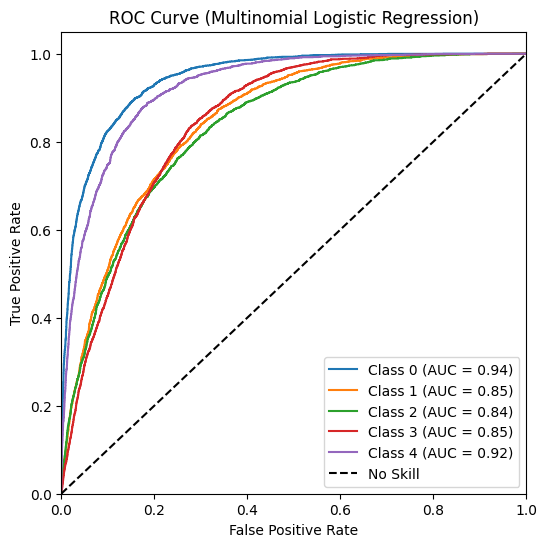

In [18]:
# Predict class labels for test data
y_pred_test = classifier.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(Y_test, y_pred_test)
print("Accuracy:", accuracy)
f1_score = f1_score(Y_test, y_pred_test, average='macro')
print("F1-Score:", f1_score)

# Calculate Confusion Matrix
confusion_matrix_result = confusion_matrix(Y_test, y_pred_test)
print("Confusion Matrix:\n", confusion_matrix_result)

# ROC Curve and AUC Score
# One-vs-Rest approach for ROC curve (as Multinomial Logistic Regression doesn't directly output probabilities)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(classifier.classes_)

for i in range(n_classes):
    y_test_binary = (Y_test == i)  # Binarize for each class
    fpr[i], tpr[i], _ = roc_curve(y_test_binary, classifier.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multinomial Logistic Regression)')
plt.legend(loc="lower right")
plt.show()

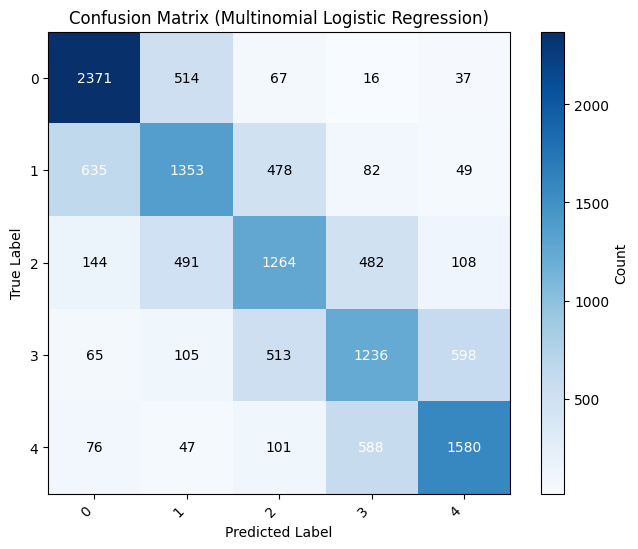

In [14]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_result, cmap='Blues')
plt.colorbar(label='Count')

# Set labels for axes
class_names = [str(x) for x in range(len(classifier.classes_))]  # Adapt based on your class names
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(range(len(class_names)), class_names)

# Add text for each cell (optional)
for i in range(len(confusion_matrix_result)):
    for j in range(len(confusion_matrix_result[0])):
        plt.text(j, i, confusion_matrix_result[i, j], ha='center', va='center', color='white' if confusion_matrix_result[i, j] > np.mean(confusion_matrix_result) else 'black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Multinomial Logistic Regression)')
plt.show()

For test set

In [19]:
X_test_test = test_df['text']
Y_test_test = test_df['label']

In [20]:
X_test_test_preprocessed = []
for text in X_test_test:
    X_test_test_preprocessed.append(preprocess(text))
X_test_test = X_test_test_preprocessed

In [23]:
x_test = vectorizer.transform(X_test_test)
x_test.toarray()
y_test = np.array(Y_test_test)

Accuracy: 0.58456
F1-Score: 0.5842360995582105
Confusion Matrix:
 [[7532 2040  213   96  119]
 [2329 5312 1879  343  137]
 [ 541 2261 4980 1848  370]
 [ 208  437 2205 5103 2047]
 [ 276  149  444 2830 6301]]


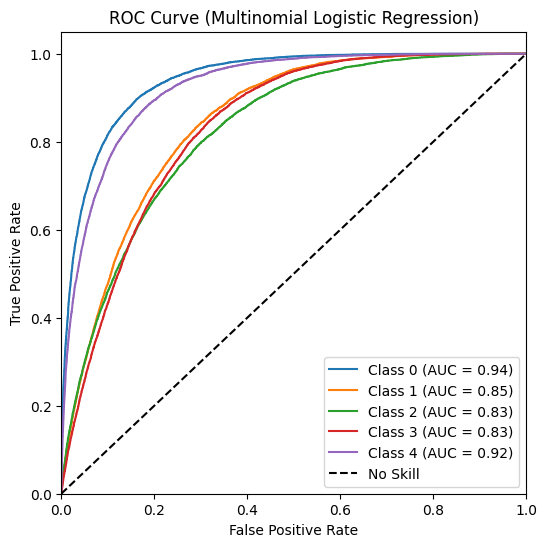

In [27]:
# Predict class labels for test data
y_pred_test = classifier.predict(x_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:", accuracy)
f1_score = metrics.f1_score(y_test, y_pred_test, average='macro')
print("F1-Score:", f1_score)

# Calculate Confusion Matrix
confusion_matrix_result = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:\n", confusion_matrix_result)

# ROC Curve and AUC Score
# One-vs-Rest approach for ROC curve (as Multinomial Logistic Regression doesn't directly output probabilities)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(classifier.classes_)

for i in range(n_classes):
    y_test_binary = (y_test == i)  # Binarize for each class
    fpr[i], tpr[i], _ = roc_curve(y_test_binary, classifier.predict_proba(x_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multinomial Logistic Regression)')
plt.legend(loc="lower right")
plt.show()

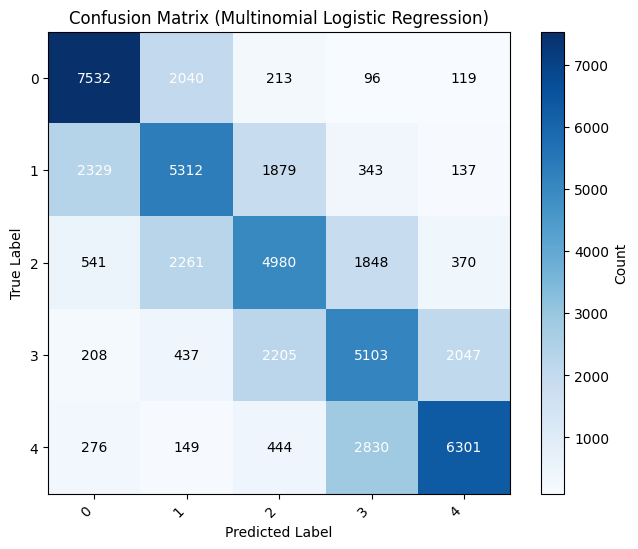

In [28]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_result, cmap='Blues')
plt.colorbar(label='Count')

# Set labels for axes
class_names = [str(x) for x in range(len(classifier.classes_))]  # Adapt based on your class names
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(range(len(class_names)), class_names)

# Add text for each cell (optional)
for i in range(len(confusion_matrix_result)):
    for j in range(len(confusion_matrix_result[0])):
        plt.text(j, i, confusion_matrix_result[i, j], ha='center', va='center', color='white' if confusion_matrix_result[i, j] > np.mean(confusion_matrix_result) else 'black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Multinomial Logistic Regression)')
plt.show()